In [3]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_finance.circuit.library import LogNormalDistribution

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#number of qubits to represent the uncertainty
num_uncertainty_qubits = 1

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

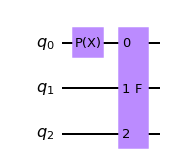

In [5]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 1.896

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.draw(output='mpl')

In [6]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[1],
    post_processing=european_call_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)

In [7]:
ae_circuit = ae.construct_circuit(problem)

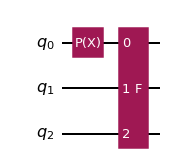

In [8]:
ae_circuit.decompose().draw(
    "mpl", style="iqx"
)  # decompose 1 level: exposes the Phase estimation circuit!

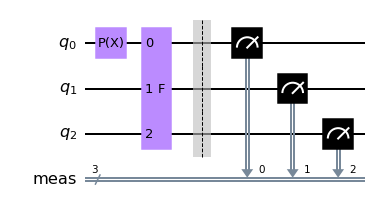

In [9]:
qc2 = QuantumCircuit(3)
qc=qc2.compose(ae_circuit)
qc.measure_all()
qc.draw()#.savefig('qae_circuit.pdf')

In [1]:
# #choosing the qasm simulator backend

# backend = Aer.get_backend('qasm_simulator')

# # running the job and getting results (counts)
# job = execute(qc, backend, shots=1024) # shots = no. of times you want to run the experiment
# result = job.result()
# counts = result.get_counts(qc)

# #printing and visualizing results (histogram data of experiment)
# print(counts)
# plot_histogram(counts)

In [19]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [10]:
backend_overview()

ibm_oslo                     ibm_nairobi                  ibmq_manila
--------                     -----------                  -----------
Num. Qubits:  7              Num. Qubits:  7              Num. Qubits:  5
Pending Jobs: 6              Pending Jobs: 23             Pending Jobs: 7
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      123.3          Avg. T1:      121.9          Avg. T1:      152.5
Avg. T2:      98.7           Avg. T2:      53.3           Avg. T2:      58.2



ibmq_quito                   ibmq_belem                   ibmq_lima
----------                   ----------                   ---------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 1              Pending Jobs: 0              Pending Jobs: 0
Least busy:   False          Least busy:   True           Least busy:   False
Operational:  True           Operatio

In [23]:
backend=provider.get_backend('ibmq_manila')

In [24]:
#Execute the circuit on the backend
job=execute(qc,backend,shots=1024)

In [28]:
job.status()

<JobStatus.QUEUED: 'job is queued'>

In [30]:
result=job.result()
counts=result.get_counts()
histogram = plot_histogram(counts,title="QAE on IBMQ_Manila")
histogram.savefig('qae_manila.pdf')


## Qiskit Runtime

SamplerResult(quasi_dists=[{'010': 0.0146484375, '000': 0.0367431640625, '011': 0.658447265625, '001': 0.2901611328125}], metadata=[{'header_metadata': {}, 'shots': 8192}])


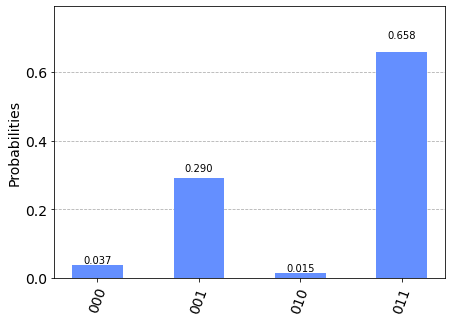

In [16]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

service = QiskitRuntimeService()

with Sampler(circuits=qc, service=service,
             #options={'backend': backend},
             options={"backend": "ibmq_qasm_simulator"},
             #options={"backend": "ibmq_belem"},
             #skip_transpilation=True
            ) as sampler:
    result = sampler(circuits=[0], shots=8192)
    print(result)
    
plot_histogram(result.quasi_dists)

In [15]:
histogram=plot_histogram(result.quasi_dists, title="QAE on IBMQ_Belem, shots = 8192")
histogram.savefig('qae_belem-8192.pdf')

In [17]:
histogram=plot_histogram(result.quasi_dists, title="QAE on Simulator, shots = 8192")
histogram.savefig('qae_sim-8192.pdf')